In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split


In [ ]:
# Cargar base de datos
df = pd.read_csv(r"C:\Users\isabe\OneDrive - Universidad Autónoma Latinoamericana\Escritorio\CD2T3\student_habits_performance.csv")

# Mostrar las primeras filas del dataset
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [9]:
# Rendimiento binario: 1 = buen rendimiento, 0 = bajo rendimiento
df['Performance'] = (df['exam_score'] >= 60).astype(int)


In [11]:
# Separar variables predictoras y objetivo
X = df.drop(['student_id', 'exam_score', 'Performance'], axis=1)
y = df['Performance']

# Codificar variables categóricas automáticamente (OneHot)
X = pd.get_dummies(X, drop_first=True)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamaño entrenamiento:", X_train.shape)
print("Tamaño prueba:", X_test.shape)

print("\nDistribución de clases en entrenamiento:\n", y_train.value_counts(normalize=True))
print("\nDistribución de clases en prueba:\n", y_test.value_counts(normalize=True))

Tamaño entrenamiento: (800, 18)
Tamaño prueba: (200, 18)

Distribución de clases en entrenamiento:
 Performance
1    0.72
0    0.28
Name: proportion, dtype: float64

Distribución de clases en prueba:
 Performance
1    0.72
0    0.28
Name: proportion, dtype: float64


## PIPELINE

In [14]:
# Detectar columnas booleanas en X_train y X_test
bool_cols = X_train.select_dtypes(include='bool').columns.tolist()

# Convertir columnas booleanas a int en X_train y X_test
for col in bool_cols:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)


In [15]:
# Identificar columnas numéricas y categóricas nuevamente (booleanas ahora son numéricas)
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

# Pipelines (igual que antes)
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("X_train procesado:", X_train_processed.shape)
print("X_test procesado:", X_test_processed.shape)


X_train procesado: (800, 18)
X_test procesado: (200, 18)


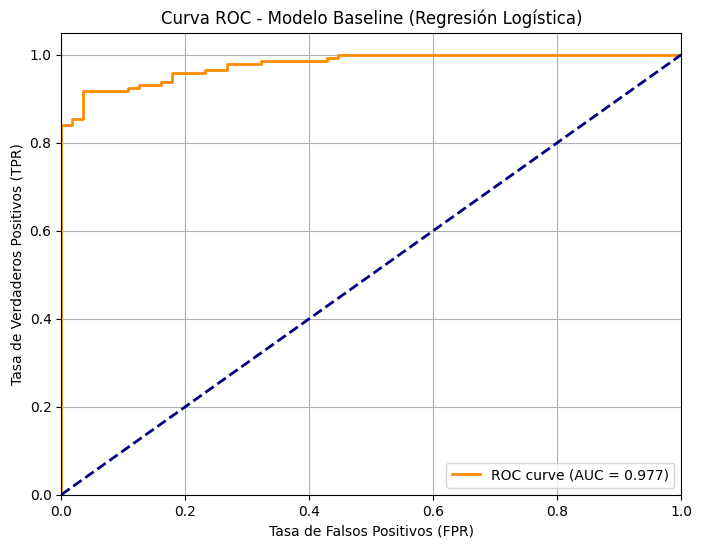

In [16]:
# Paso 4.1: Importar librerías para el modelo y evaluación
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Paso 4.2: Crear y entrenar el modelo baseline
model_baseline = LogisticRegression(random_state=42, max_iter=1000)
model_baseline.fit(X_train_processed, y_train)

# Paso 4.3: Predecir probabilidades en conjunto de prueba
y_probs = model_baseline.predict_proba(X_test_processed)[:, 1]

# Paso 4.4: Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Paso 4.5: Graficar curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo Baseline (Regresión Logística)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


El área bajo la curva ROC (AUC) mide la capacidad del modelo para distinguir entre clases positivas y negativas.

Un valor cercano a 1 indica que el modelo tiene un altísimo poder de discriminación.

Por ejemplo, si tomas un par de estudiantes, uno con buen rendimiento y otro con bajo rendimiento, el modelo tendrá un 97.7% de probabilidad de asignarle una probabilidad más alta al estudiante con buen rendimiento.

In [17]:
# Espacio de hiperparámetros para LogisticRegression
param_dist = {
    'C': [0.01, 0.1, 1, 10, 100],                      # escala logarítmica típica
    'penalty': ['l1', 'l2', 'elasticnet'],             # tipos de regularización
    'solver': ['saga'],                                 # saga soporta todas las penalties
    'l1_ratio': [0, 0.5, 1],                           # solo usado para elasticnet
    'max_iter': [1000]                                  # suficiente para converger
}


In [18]:
from sklearn.model_selection import RandomizedSearchCV

# Crear el modelo base
model = LogisticRegression(random_state=42, max_iter=1000, solver='saga')

# Espacio de hiperparámetros para búsqueda aleatoria
param_dist = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': [0, 0.5, 1]  # solo usado si penalty='elasticnet'
}

# Custom para manejar l1_ratio solo cuando penalty='elasticnet'
def param_sampler():
    import random
    while True:
        penalty = random.choice(param_dist['penalty'])
        if penalty == 'elasticnet':
            l1_ratio = random.choice(param_dist['l1_ratio'])
        else:
            l1_ratio = None
        C = random.choice(param_dist['C'])
        yield {'penalty': penalty, 'l1_ratio': l1_ratio, 'C': C, 'solver': 'saga', 'max_iter': 1000}

# Función para filtrar parámetros no válidos
from sklearn.base import clone
from sklearn.utils.validation import _deprecate_positional_args

from sklearn.model_selection import ParameterSampler
param_list = list(ParameterSampler(param_dist, n_iter=20, random_state=42))

# Ajustamos RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    verbose=1,
    refit=True
)

random_search.fit(X_train_processed, y_train)
print("Mejores hiperparámetros búsqueda aleatoria:")
print(random_search.best_params_)
print(f"Mejor AUC (CV): {random_search.best_score_:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196:

Mejores hiperparámetros búsqueda aleatoria:
{'penalty': 'elasticnet', 'l1_ratio': 1, 'C': 1}
Mejor AUC (CV): 0.9742


c:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196:

In [21]:
pip install optuna


   ---------------------------------------- 0.0/386.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/386.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/386.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/386.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/386.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/386.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/386.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/386.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/386.6 kB ? eta -:--:--
   --- ----------------------------------- 30.7/386.6 kB 262.6 kB/s eta 0:00:02
   --- ----------------------------------- 30.7/386.6 kB 262.6 kB/s eta 0:00:02
   ---- ---------------------------------- 41.0/386.6 kB 164.3 kB/s eta 0:00:03
   ---- ---------------------------------- 41.0/386.6 kB 164.3 kB/s eta 0:00:03
   ------ -----------------------------


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    C = trial.suggest_loguniform('C', 0.01, 100)
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0, 1)

    params = {
        'penalty': penalty,
        'C': C,
        'solver': 'saga',
        'max_iter': 1000,
        'random_state': 42
    }
    if l1_ratio is not None:
        params['l1_ratio'] = l1_ratio

    clf = LogisticRegression(**params)
    scores = cross_val_score(clf, X_train_processed, y_train, cv=5, scoring='roc_auc')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Mejores hiperparámetros Optuna:")
print(study.best_params)
print(f"Mejor AUC (CV) Optuna: {study.best_value:.4f}")


c:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-16 20:41:16,502] A new study created in memory with name: no-name-f1456d11-2c0e-4f66-b64d-cbd4b498f49a
C:\Users\isabe\AppData\Local\Temp\ipykernel_22176\4192267264.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 100)
[I 2025-05-16 20:41:16,541] Trial 0 finished with value: 0.9739005572971091 and parameters: {'penalty': 'elasticnet', 'C': 0.30791710323144483, 'l1_ratio': 0.3247796564804709}. Best is trial 0 with value: 0.9739005572971091.
C:\Users\isabe\AppData\Local\Temp\ipykernel_22176\4192267264.py:

Mejores hiperparámetros Optuna:
{'penalty': 'elasticnet', 'C': 0.26063968248094144, 'l1_ratio': 0.8863394837911348}
Mejor AUC (CV) Optuna: 0.9755


## Validación cruzada

In [23]:
from sklearn.model_selection import cross_val_score

# Modelo baseline (sin ajuste)
baseline_model = LogisticRegression(random_state=42, max_iter=1000, solver='saga')
baseline_scores = cross_val_score(baseline_model, X_train_processed, y_train, cv=5, scoring='roc_auc')

# Mejor modelo búsqueda aleatoria
best_random_params = random_search.best_params_
random_model = LogisticRegression(**best_random_params, max_iter=1000, solver='saga', random_state=42)
random_scores = cross_val_score(random_model, X_train_processed, y_train, cv=5, scoring='roc_auc')

# Mejor modelo Optuna
best_optuna_params = study.best_params
# Agregar max_iter y random_state porque no están en params
best_optuna_params['max_iter'] = 1000
best_optuna_params['solver'] = 'saga'
best_optuna_params['random_state'] = 42

optuna_model = LogisticRegression(**best_optuna_params)
optuna_scores = cross_val_score(optuna_model, X_train_processed, y_train, cv=5, scoring='roc_auc')

# Resultados
import pandas as pd

results = pd.DataFrame({
    'Modelo': ['Baseline', 'Búsqueda Aleatoria', 'Optuna'],
    'AUC CV media': [baseline_scores.mean(), random_scores.mean(), optuna_scores.mean()],
    'AUC CV std': [baseline_scores.std(), random_scores.std(), optuna_scores.std()]
})

print(results)


               Modelo  AUC CV media  AUC CV std
0            Baseline      0.973362    0.007585
1  Búsqueda Aleatoria      0.974176    0.007401
2              Optuna      0.975488    0.006695


Los resultados muestran que los modelos ajustados con búsqueda aleatoria y Optuna mejoran un poco el desempeño respecto al baseline, siendo Optuna el que mejor AUC promedio y menor desviación tiene.

In [24]:
from sklearn.metrics import roc_auc_score

# Entrenar modelos con mejores parámetros en todo X_train
baseline_model.fit(X_train_processed, y_train)

random_model = LogisticRegression(**best_random_params, max_iter=1000, solver='saga', random_state=42)
random_model.fit(X_train_processed, y_train)

optuna_model = LogisticRegression(**best_optuna_params)
optuna_model.fit(X_train_processed, y_train)

# Predecir probabilidades en conjunto de prueba
y_proba_baseline = baseline_model.predict_proba(X_test_processed)[:, 1]
y_proba_random = random_model.predict_proba(X_test_processed)[:, 1]
y_proba_optuna = optuna_model.predict_proba(X_test_processed)[:, 1]

# Calcular AUC en test
auc_baseline = roc_auc_score(y_test, y_proba_baseline)
auc_random = roc_auc_score(y_test, y_proba_random)
auc_optuna = roc_auc_score(y_test, y_proba_optuna)

print(f"AUC Test Baseline: {auc_baseline:.4f}")
print(f"AUC Test Búsqueda Aleatoria: {auc_random:.4f}")
print(f"AUC Test Optuna: {auc_optuna:.4f}")


AUC Test Baseline: 0.9773
AUC Test Búsqueda Aleatoria: 0.9778
AUC Test Optuna: 0.9785


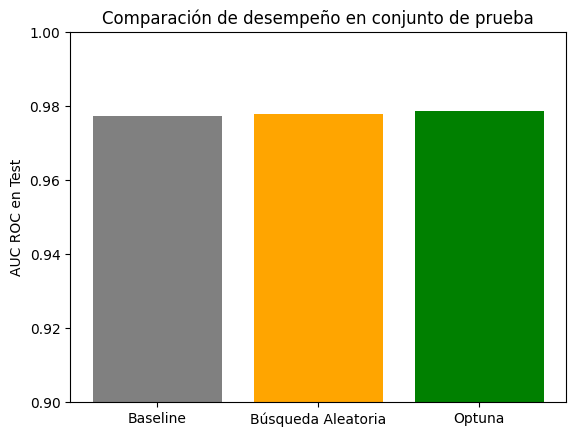

In [25]:
plt.bar(['Baseline', 'Búsqueda Aleatoria', 'Optuna'],
        [auc_baseline, auc_random, auc_optuna],
        color=['gray', 'orange', 'green'])
plt.ylabel('AUC ROC en Test')
plt.title('Comparación de desempeño en conjunto de prueba')
plt.ylim(0.9, 1)
plt.show()


El modelo baseline ya tenía un desempeño alto (AUC ~0.9773).

La búsqueda aleatoria mejoró un poco (0.9778).

Optuna logró la mejor puntuación (0.9785), mostrando que la optimización bayesiana fue efectiva para encontrar parámetros más adecuados.



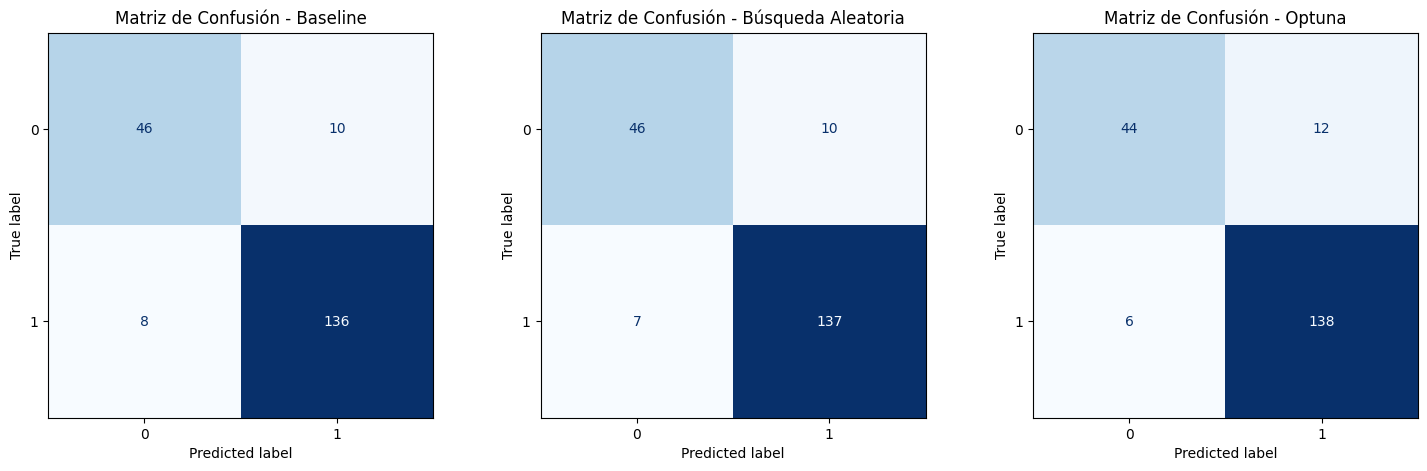

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for model, ax, title in zip([baseline_model, random_model, optuna_model],
                           axes,
                           ['Baseline', 'Búsqueda Aleatoria', 'Optuna']):
    y_pred = model.predict(X_test_processed)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'Matriz de Confusión - {title}')

plt.show()


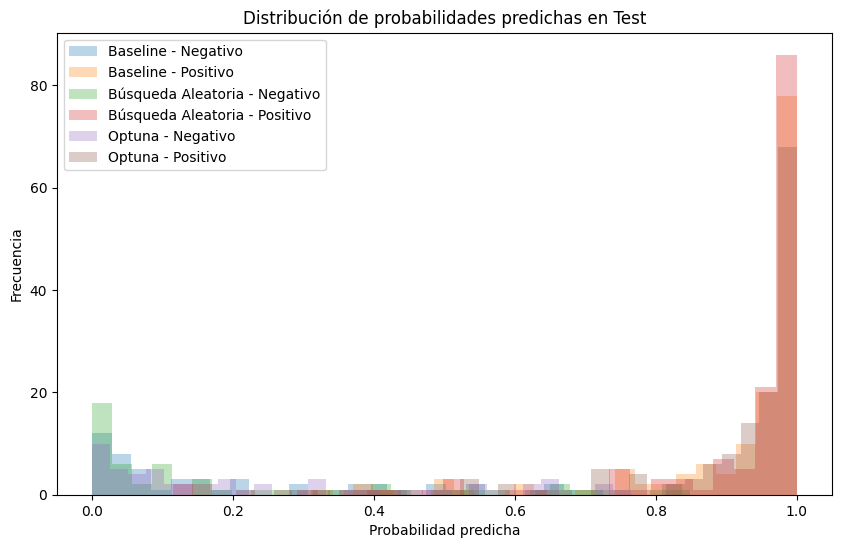

In [28]:
plt.figure(figsize=(10,6))

for model, label in zip([baseline_model, random_model, optuna_model],
                        ['Baseline', 'Búsqueda Aleatoria', 'Optuna']):
    y_proba = model.predict_proba(X_test_processed)[:, 1]
    plt.hist(y_proba[y_test == 0], bins=30, alpha=0.3, label=f'{label} - Negativo')
    plt.hist(y_proba[y_test == 1], bins=30, alpha=0.3, label=f'{label} - Positivo')

plt.title('Distribución de probabilidades predichas en Test')
plt.xlabel('Probabilidad predicha')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


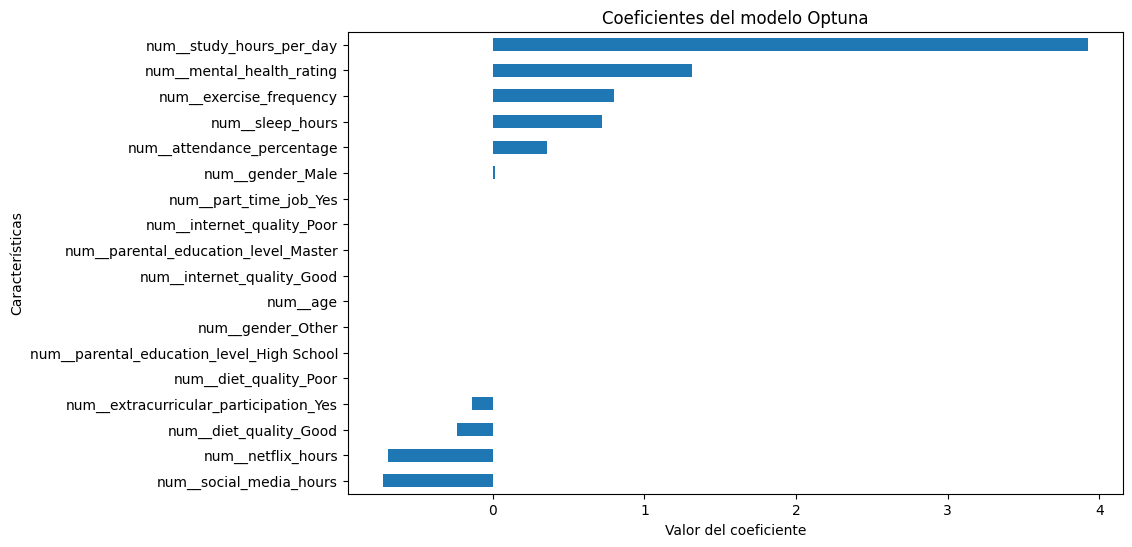

In [29]:
import numpy as np

coefs = pd.Series(optuna_model.coef_[0], index=preprocessor.get_feature_names_out())
coefs_sorted = coefs.sort_values()

plt.figure(figsize=(10,6))
coefs_sorted.plot(kind='barh')
plt.title('Coeficientes del modelo Optuna')
plt.xlabel('Valor del coeficiente')
plt.ylabel('Características')
plt.show()
